In [ ]:
%pip install scikit-learn imbalanced-learn==0.11.0
%pip install matplotlib
%pip install seaborn
%pip install mlflow dagshub
%pip install xgboost

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
import dagshub
import mlflow

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# to ignore warnings in cells
warnings.filterwarnings('ignore')

In [4]:
random_state = 42

def show_na_means(df):
  na_means = df.isna().mean().sort_values(ascending=False)
  print(na_means[na_means > 0])

def get_cat_num_cols(df):
  cat_cols = [col for col in df.columns if df[col].dtype == 'object']
  num_cols = [col for col in df.columns if df[col].dtype != 'object']
  return (cat_cols, num_cols)

In [5]:
df_train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
df_train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

In [6]:
df_train = pd.merge(df_train_transaction, df_train_identity, on="TransactionID", how="left")

In [7]:
df_train.drop('TransactionID', axis=1, inplace=True)

# Authorize on DagsHub

In [8]:
import dagshub
dagshub.init(repo_owner='b3tameche', repo_name='kaggle-fraud-detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=6ea77bf4-6c91-4cff-8c17-34c6927d2743&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=6ae54664d475c17a14975f5a2ce97e2a2eef7f111161b67c71e35317dc7b2b1f




Output()

Accessing as b3tameche

Initialized MLflow to track repo "b3tameche/kaggle-fraud-detection"

Repository b3tameche/kaggle-fraud-detection initialized!

# Train/Test Split

In [9]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=random_state)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = X_train.pop('isFraud')
y_test = X_test.pop('isFraud')

# Preprocessing

## Fetch General Preprocessor

In [10]:
preprocessor_name = "general_preprocessor"
preprocessor_version = "1"

preprocessor_uri = f'models:/{preprocessor_name}/{preprocessor_version}'

general_preprocessor = mlflow.sklearn.load_model(preprocessor_uri)

In [11]:
general_preprocessor

Pipeline(steps=[('na_filler', SimpleNAPreprocessor()),
                ('encoder',
                 EncoderPreprocessor(onehot_prefix='onehott',
                                     onehot_threshold=3)),
                ('feature_engineer',
                 FeatureEngineeringPreprocessor(transaction_dt_column_name='TransactionDT'))])

## Column Transformer

In [14]:
class ColumnTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        return self

    def transform(self, X):
        X_work = X.copy()
        old_names = X.columns
        new_names = [col.replace('-', '_') for col in old_names]
        X_work.columns = new_names
        return X_work

# Training

## Feature Selection Phase

In [15]:
feature_selection_pipeline_steps = [('column_transformer', ColumnTransformer())]
feature_selection_pipeline_steps += [(name, step) for name, step in general_preprocessor.steps]
feature_selection_pipeline_steps += [('undersampler', RandomUnderSampler(random_state=random_state, sampling_strategy=0.33))]
feature_selection_pipeline_steps += [('classifier', xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.3,
    random_state=random_state,
    eval_metric="auc",
    tree_method="hist",
    use_label_encoder=False,
))]

feature_selection_pipeline = ImbPipeline(steps=feature_selection_pipeline_steps)

feature_selection_pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer', ColumnTransformer()),
                ('na_filler', SimpleNAPreprocessor()),
                ('encoder',
                 EncoderPreprocessor(onehot_prefix='onehott',
                                     onehot_threshold=3)),
                ('feature_engineer',
                 FeatureEngineeringPreprocessor(transaction_dt_column_name='TransactionDT')),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.33)),
                ('clas...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

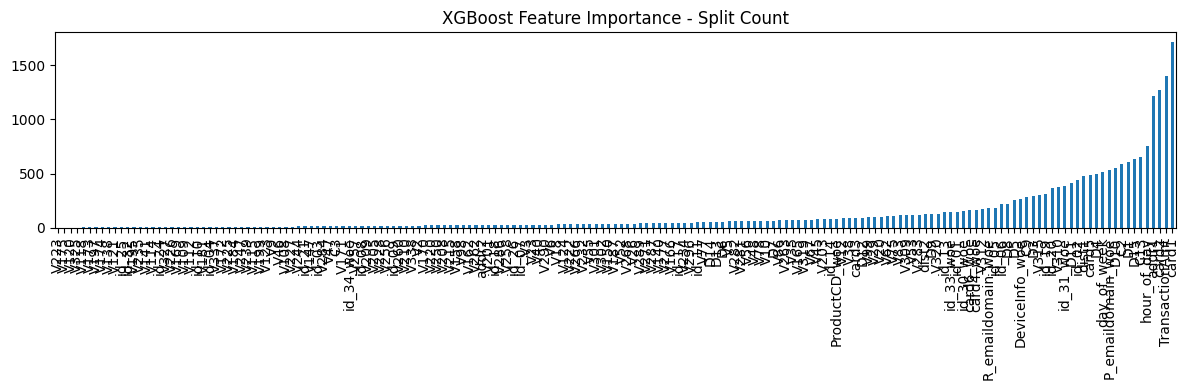

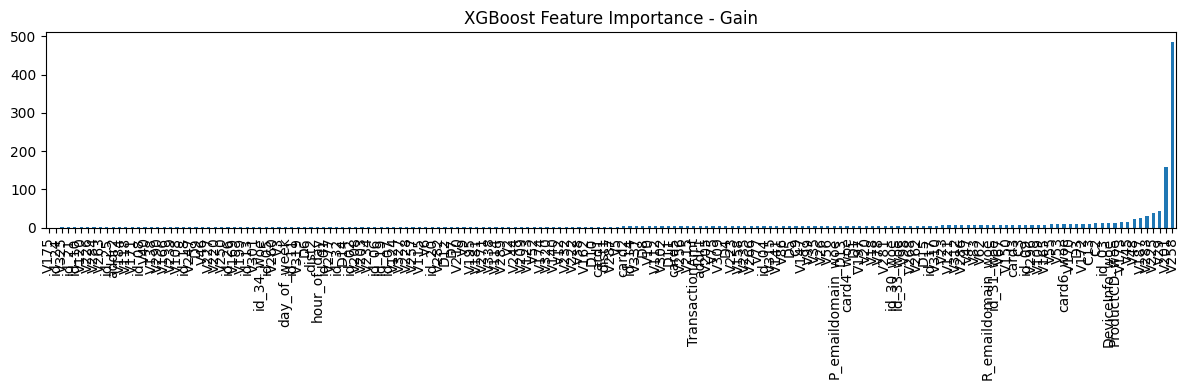

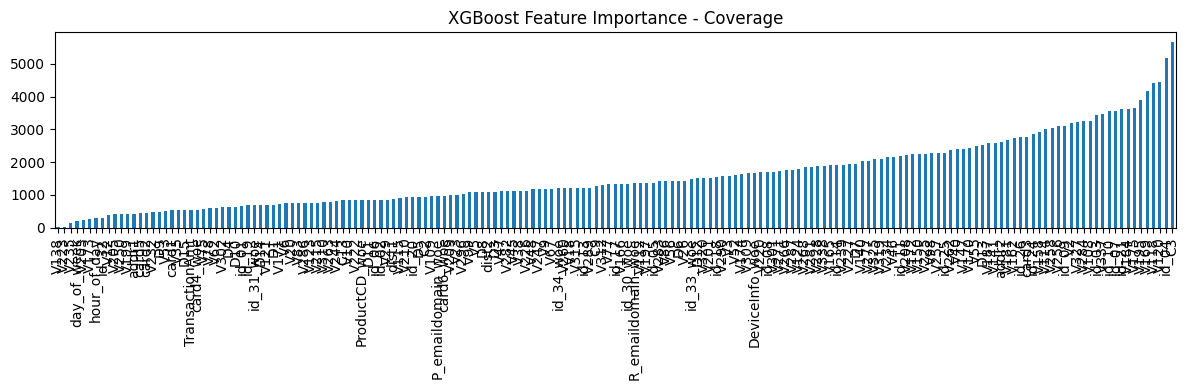

In [16]:
model = feature_selection_pipeline['classifier']

# Split count
model_split_importances = model.get_booster().get_score(importance_type='weight')

# Info gain
model_gain_importances = model.get_booster().get_score(importance_type='gain')

# Coverage
model_cover_importances = model.get_booster().get_score(importance_type='cover')

# Convert to series and plot
for name, scores in zip(['Split Count', 'Gain', 'Coverage'], [model_split_importances, model_gain_importances, model_cover_importances]):
    s = pd.Series(scores).sort_values()
    s.plot(kind="bar", figsize=(12, 4), title=f"XGBoost Feature Importance - {name}")
    plt.tight_layout()
    plt.show()

In [17]:
sorted_model_gain_importances = {k: v for k, v in sorted(model_gain_importances.items(), key=lambda item: -item[1])}

sorted_features = list(sorted_model_gain_importances.keys())
sorted_gain_importances = list(sorted_model_gain_importances.values())

In [18]:
len(sorted_features)

177

In [27]:
X_train_transformed = ColumnTransformer().transform(X_train)
X_train_transformed = general_preprocessor.transform(X_train_transformed)
X_train_transformed, y_train_transformed = RandomUnderSampler(random_state=random_state, sampling_strategy=0.33).fit_resample(X_train_transformed, y_train)

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

possible_feature_counts = [75, 100, 120, len(sorted_features)]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_aucs = []

for count in possible_feature_counts:
    count = min(count, len(sorted_features))
    selected_features = sorted_features[:count]
    X_selected = X_train_transformed[selected_features]
    
    fold_aucs = []
    for train_idx, val_idx in skf.split(X_selected, y_train_transformed):
        X_fold_train, X_fold_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_fold_train, y_fold_val = y_train_transformed.iloc[train_idx], y_train_transformed.iloc[val_idx]
        
        fold_model = xgb.XGBClassifier(
            objective="binary:logistic",
            n_estimators=1000,
            max_depth=5,
            learning_rate=0.3,
            random_state=random_state,
            eval_metric="auc",
            tree_method="hist",
            use_label_encoder=False,
        )
        fold_model.fit(X_fold_train, y_fold_train)
        
        y_pred_proba = fold_model.predict_proba(X_fold_val)[:,1]
        fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        fold_aucs.append(fold_auc)

    # calculate mean for current folds
    mean_auc = np.mean(fold_aucs)
    cv_aucs.append(mean_auc)
    print(f"Feature count: {count}, ROC-AUC: {mean_auc:.4f}")

Feature count: 75, ROC-AUC: 0.9391
Feature count: 100, ROC-AUC: 0.9542
Feature count: 120, ROC-AUC: 0.9544
Feature count: 177, ROC-AUC: 0.9535


**Best score with 120 features.**

In [30]:
class FeatureSelector(BaseEstimator, TransformerMixin):
  def __init__(self, selected_features: set[str]):
    self.selected_features = selected_features
  
  def fit(self, X, y):
    return self

  def transform(self, X):
    X_work = X.copy()
    X_work = X_work[list(self.selected_features)]
    return X_work

## Training Phase

In [31]:
selected_features = sorted_features[:120]
feature_selector = FeatureSelector(selected_features=selected_features)

In [32]:
# final_steps_gs = [(name, step) for name, step in general_preprocessor.steps]
# final_steps_gs += [('feature_selector', feature_selector)]
# final_steps_gs += [('undersampler', RandomUnderSampler(random_state=random_state, sampling_strategy=0.33))]
    
# final_steps_gs += [('classifier', xgb.XGBClassifier(
#     objective="binary:logistic",
#     n_estimators=1000,
#     max_depth=5,
#     learning_rate=0.3,
#     random_state=random_state,
#     eval_metric="auc",
#     tree_method="hist",
#     use_label_encoder=False,
# ))]

# final_pipeline_gs = ImbPipeline(steps=final_steps_gs)

# param_grid = {
#     'classifier__n_estimators': [700, 1000, 1500],
#     'classifier__max_depth': [5, 7],
#     'classifier__learning_rate': [0.01, 0.1, 0.3]
# }

# grid_search = GridSearchCV(
#     estimator=final_pipeline_gs,
#     param_grid=param_grid,
#     scoring='roc_auc'
# )

# grid_search.fit(X_train, y_train)

In [33]:
final_steps_gs = [('column_transformer', ColumnTransformer())]
final_steps_gs += [(name, step) for name, step in general_preprocessor.steps]
final_steps_gs += [('feature_selector', feature_selector)]
final_steps_gs += [('undersampler', RandomUnderSampler(random_state=random_state, sampling_strategy=0.33))]
    
final_steps_gs += [('classifier', xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.3,
    random_state=random_state,
    eval_metric="auc",
    tree_method="hist",
    use_label_encoder=False,
))]

final_pipeline_gs = ImbPipeline(steps=final_steps_gs)

final_pipeline_gs.fit(X_train, y_train)

Pipeline(steps=[('column_transformer', ColumnTransformer()),
                ('na_filler', SimpleNAPreprocessor()),
                ('encoder',
                 EncoderPreprocessor(onehot_prefix='onehott',
                                     onehot_threshold=3)),
                ('feature_engineer',
                 FeatureEngineeringPreprocessor(transaction_dt_column_name='TransactionDT')),
                ('feature_selector',
                 FeatureSelector(selected_features=['V258', 'V201', 'V29',
                                                    'V225',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

# MLFlow Tracking

## Log Feature Selection

In [34]:
sorted_model_split_importances = {k: v for k, v in sorted(model_split_importances.items(), key=lambda item: -item[1])}
sorted_model_cover_importances = {k: v for k, v in sorted(model_cover_importances.items(), key=lambda item: -item[1])}

In [35]:
experiment_name = "XGBoost_Training"
feature_selection_run_name = "XGBoost_Feature_Selection"

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=feature_selection_run_name):
    mlflow.log_dict(sorted_model_split_importances, "sorted_model_split_importances.json")
    mlflow.log_dict(sorted_model_gain_importances, "sorted_model_gain_importances.json")
    mlflow.log_dict(sorted_model_cover_importances, "sorted_model_cover_importances.json")

    mlflow.log_param('selected_features', selected_features)

🏃 View run XGBoost_Feature_Selection at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/4/runs/169ca68d3eb64b83aba87474dd686c31
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/4


## Log Training

In [36]:
classifier = final_pipeline_gs['classifier']

# make predictions
pred_train = final_pipeline_gs.predict(X_train)

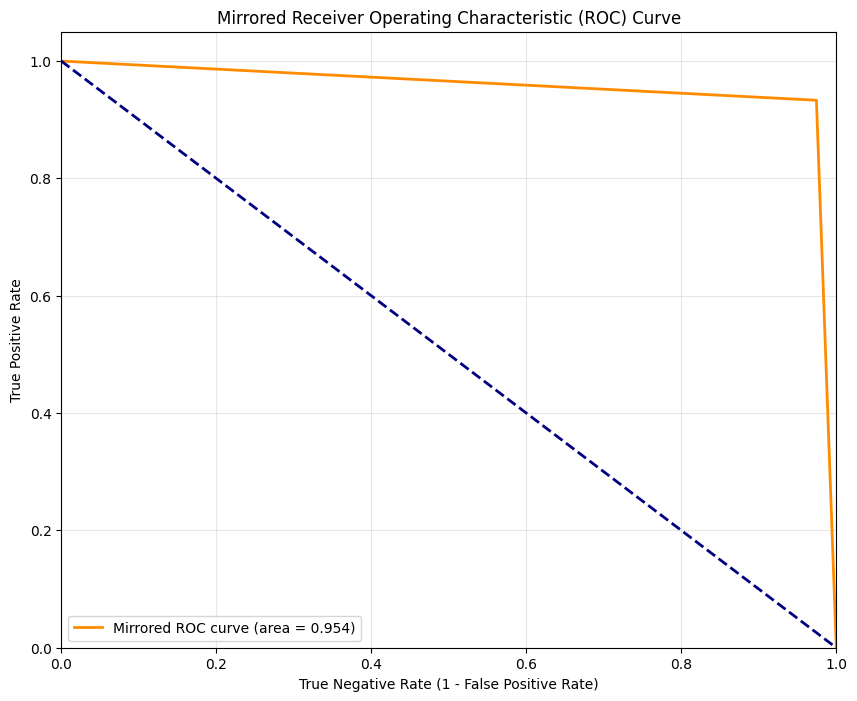

In [37]:
# Evaluate metrics

# [[True Negative, False Positive],
#  [False Negative, True Positive]]
conf_matrix = confusion_matrix(y_train, pred_train)
conf_matrix_dict = {
    "TN": conf_matrix[0][0],
    "FP": conf_matrix[0][1],
    "FN": conf_matrix[1][0],
    "TP": conf_matrix[1][1]
}

classification_report_dict = classification_report(y_train, pred_train, output_dict=True)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, pred_train)
roc_auc = auc(fpr, tpr)

tnr = 1 - fpr

plt.figure(figsize=(10, 8))

plt.plot(tnr, tpr, color='darkorange', lw=2, 
         label=f'Mirrored ROC curve (area = {roc_auc:.3f})')

# Plot diagonal line (represents random classifier)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('True Negative Rate (1 - False Positive Rate)')
plt.ylabel('True Positive Rate')
plt.title('Mirrored Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower left")

# Display the plot
plt.grid(alpha=0.3)

plt.savefig("XGBoost_ROC_Curve.png")

In [38]:
experiment_name = "XGBoost_Training"
training_run_name = "XGBoost_Training"

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=training_run_name):
    mlflow.log_param("classifier_objective", classifier.objective)
    mlflow.log_param("classifier_n_estimators", classifier.n_estimators)
    mlflow.log_param("classifier_max_depth", classifier.max_depth)
    mlflow.log_param("classifier_learning_rate", classifier.learning_rate)
    mlflow.log_param("classifier_random_state", classifier.random_state)
    mlflow.log_param("classifier_eval_metric", classifier.eval_metric)
    mlflow.log_param("classifier_tree_method", classifier.tree_method)

    mlflow.log_dict(conf_matrix_dict, "confusion_matrix.json")
    mlflow.log_dict(classification_report_dict, "classification_report.json")

    mlflow.log_artifact("XGBoost_ROC_Curve.png")
    mlflow.log_metric("auc_roc", roc_auc)

    mlflow.sklearn.log_model(final_pipeline_gs, "pipeline_XGBoost")

2025/04/22 22:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Training at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/4/runs/22f2634ee44a45d5a22d14cac6ccaadb
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/4
